# EDA and Feature Selection

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm

## Load the datasets

In [2]:
train_raw = pd.read_csv('./datasets/train.csv')
train = pd.read_csv('./datasets/train_clean.csv')
kaggle = pd.read_csv('./datasets/kaggle_clean.csv')

In [3]:
# Check for nulls
print(train.isnull().sum().sum())
print(kaggle.isnull().sum().sum())

0
0


In [4]:
# Columns present in the train dataset which are not in the kaggle dataset
col_no_kag = []
for col in train.columns:
    if col not in kaggle.columns:
        col_no_kag.append(col)
col_no_kag.remove('saleprice')

In [5]:
X = train.drop(['saleprice','id','pid'], axis=1)
X_sp = train.drop(['id','pid'], axis=1)
y = train['saleprice']

In [6]:
kaggle.drop(['id','pid'], axis=1, inplace=True)

## Exploratory Data Analysis

Features having the most co-relation with the sales price

In [7]:
X_sp.corr()['saleprice'][X_sp.corr()['saleprice'].abs() > 0.5].sort_values(ascending=False)

saleprice           1.000000
overall_qual        0.800207
exter_qual          0.712146
gr_liv_area         0.697038
kitchen_qual        0.692336
garage_area         0.650241
garage_cars         0.648128
total_bsmt_sf       0.629303
1st_flr_sf          0.618486
bsmt_qual           0.612188
year_built          0.571849
garage_finish       0.557839
year_remod/add      0.550370
garage_yr_blt       0.550324
fireplace_qu        0.538925
full_bath           0.537969
foundation_PConc    0.529047
totrms_abvgrd       0.504014
mas_vnr_area        0.503579
Name: saleprice, dtype: float64

Plotting the continuous variables from above against the sale price

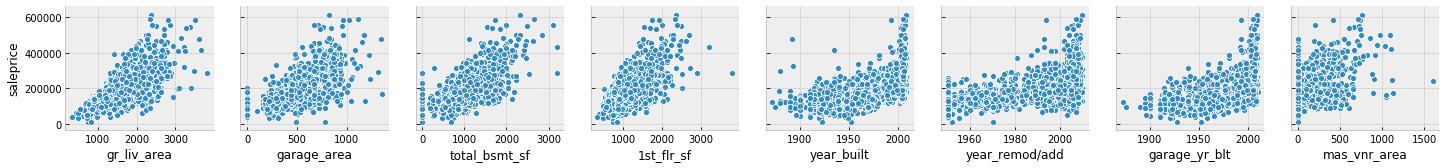

In [75]:
sns.pairplot(X_sp, x_vars=['gr_liv_area','garage_area','total_bsmt_sf','1st_flr_sf','year_built','year_remod/add',
                          'garage_yr_blt','mas_vnr_area'], y_vars=['saleprice']);

Looking at the plots of 'Sale price' vs 'Above ground living area' and 'Sale price' vs 'Garage year built', 
three outliers are observed which will be removed from the dataset to prevent mispredictions.

In [9]:
train[train['gr_liv_area'] > 4000]

id        pid  lot_frontage  lot_area  lot_shape  utilities  \
960   1499  908154235         313.0     63887          1          4   
1885  2181  908154195         128.0     39290          3          4   

      land_slope  overall_qual  overall_cond  year_built  ...  \
960            3            10             5        2008  ...   
1885           3            10             5        2008  ...   

      misc_feature_Shed  misc_feature_TenC  sale_type_CWD  sale_type_Con  \
960                   0                  0              0              0   
1885                  0                  0              0              0   

      sale_type_ConLD  sale_type_ConLI  sale_type_ConLw  sale_type_New  \
960                 0                0                0              1   
1885                0                0                0              1   

      sale_type_Oth  sale_type_WD   
960               0              0  
1885              0              0  

[2 rows x 213 columns]

In [10]:
X.drop([960, 1885], axis=0, inplace=True,)
X_sp.drop([960, 1885], axis=0, inplace=True)
y.drop([960, 1885], axis=0, inplace=True)

In [11]:
train[train['garage_yr_blt'] > 2010]

id        pid  lot_frontage  lot_area  lot_shape  utilities  \
1699  2261  916384070          68.0      8298          3          4   

      land_slope  overall_qual  overall_cond  year_built  ...  \
1699           3             8             5        2006  ...   

      misc_feature_Shed  misc_feature_TenC  sale_type_CWD  sale_type_Con  \
1699                  0                  0              0              0   

      sale_type_ConLD  sale_type_ConLI  sale_type_ConLw  sale_type_New  \
1699                0                0                0              1   

      sale_type_Oth  sale_type_WD   
1699              0              0  

[1 rows x 213 columns]

In [12]:
X.drop(1699, axis=0, inplace=True,)
X_sp.drop(1699, axis=0, inplace=True)
y.drop(1699, axis=0, inplace=True)

Checking for Homoskedasticity of Residuals

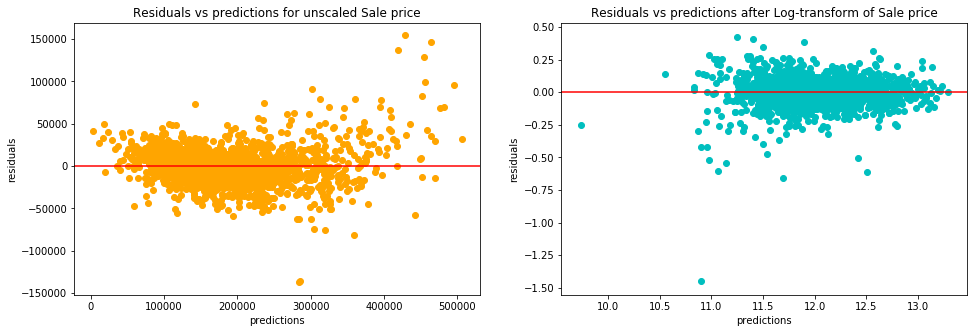

In [13]:
lm = LinearRegression()
lm.fit(X, y)
y_preds = lm.predict(X)

lm.fit(X,np.log(y))
y_preds_log = lm.predict(X)

fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax[0].scatter(y_preds, y-y_preds, color = 'orange')
ax[0].set_xlabel('predictions')
ax[0].set_ylabel('residuals');
ax[0].set_title('Residuals vs predictions for unscaled Sale price')
ax[0].axhline(y=(y-y_preds).mean(), color='red')
ax[1].scatter(y_preds_log, np.log(y)-y_preds_log, color = 'c');
ax[1].set_xlabel('predictions')
ax[1].set_ylabel('residuals');
ax[1].set_title('Residuals vs predictions after Log-transform of Sale price');
ax[1].axhline(y=(np.log(y)-y_preds_log).mean(), color='red');

Checking for Normality of Residuals

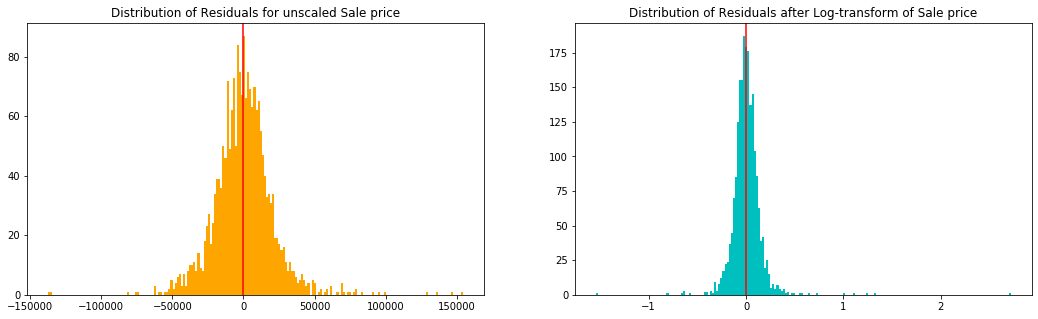

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (18, 5))
ax[0].hist(y-y_preds, color = 'orange', bins=200)
ax[1].hist(np.log(y)-np.log(y_preds), color = 'c', bins=200);
ax[0].set_title('Distribution of Residuals for unscaled Sale price')
ax[0].axvline(x=(y-y_preds).mean(), color='red')
ax[1].axvline(x=(np.log(y)-y_preds_log).mean(), color='red');
ax[1].set_title('Distribution of Residuals after Log-transform of Sale price');

It can be seen that the log-transformed sale price has a more normal distribution, and results in more Homoskedasticity than unscaled sale price, so the sale price will be log-transformed.

In [15]:
y = np.log(y)

### Other observed trends

Text(0, 0.5, 'Distribution of Sale Price')

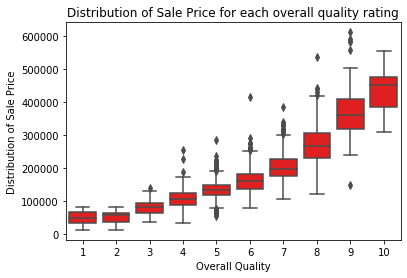

In [16]:
sns.boxplot(X_sp['overall_qual'], X_sp['saleprice'], color='r')
plt.title('Distribution of Sale Price for each overall quality rating')
plt.xlabel('Overall Quality')
plt.ylabel('Distribution of Sale Price')

Text(0, 0.5, 'Distribution of Sale Price')

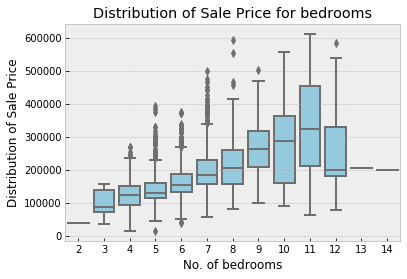

In [57]:
sns.boxplot(X_sp['totrms_abvgrd'], X_sp['saleprice'], color='skyblue')
plt.title('Distribution of Sale Price for bedrooms')
plt.xlabel('No. of bedrooms')
plt.ylabel('Distribution of Sale Price')

Text(0, 0.5, 'Sale Price')

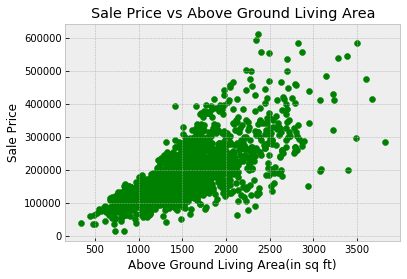

In [55]:
plt.scatter(X_sp['gr_liv_area'], X_sp['saleprice'], color='green')
plt.title('Sale Price vs Above Ground Living Area')
plt.xlabel('Above Ground Living Area(in sq ft)')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

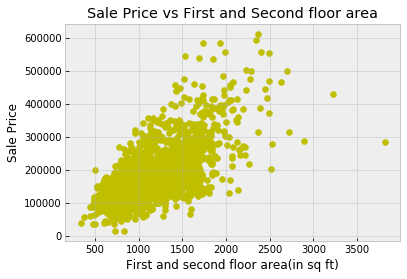

In [77]:
total_sf = X_sp['1st_flr_sf']+X_sp['2nd_flr_sf']
plt.scatter(X_sp['1st_flr_sf'], X_sp['saleprice'], color='y')
plt.title('Sale Price vs First and Second floor area')
plt.xlabel('First and second floor area(in sq ft)')
plt.ylabel('Sale Price')


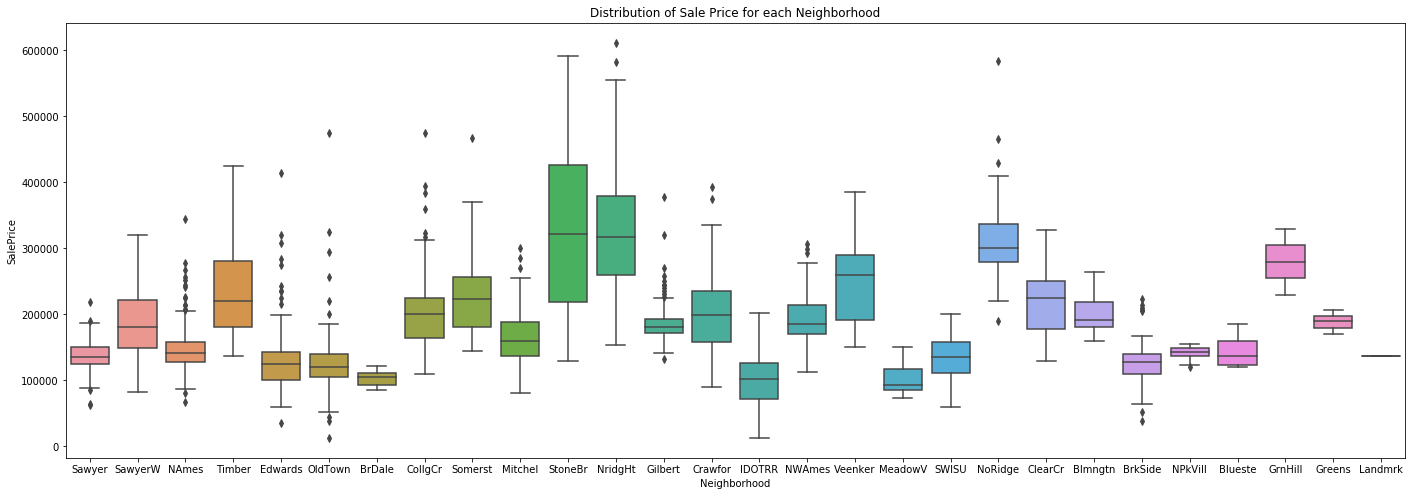

In [17]:
plt.figure(figsize=(24,8))
sns.boxplot(train_raw['Neighborhood'], train_raw['SalePrice'])
plt.title('Distribution of Sale Price for each Neighborhood');

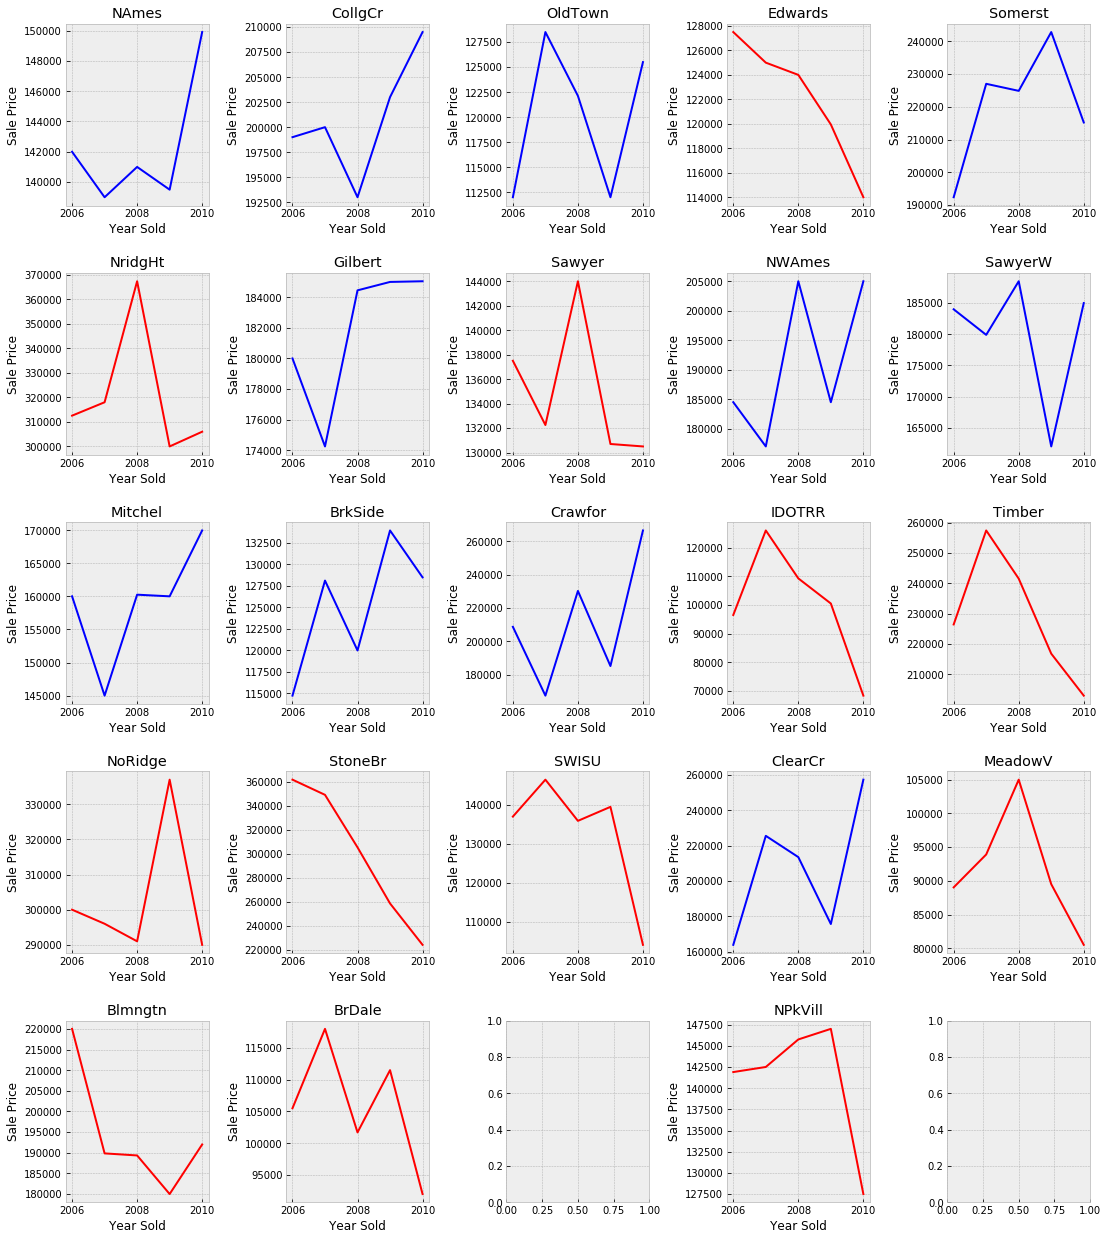

In [87]:
fig, ax = plt.subplots(5, 5, figsize = (16, 3*6))
ax = ax.ravel()
plt.style.use('bmh')
plt.tight_layout(pad=5)

for i, nbd in enumerate(train_raw['Neighborhood'].value_counts().index):
    if len(train_raw[train_raw['Neighborhood']== nbd].groupby('Yr Sold')['SalePrice'].median())==5:
        price_06 = train_raw[(train_raw['Neighborhood']== nbd)&(train_raw['Yr Sold']==2006)]['SalePrice'].median()
        price_10 = train_raw[(train_raw['Neighborhood']== nbd)&(train_raw['Yr Sold']==2010)]['SalePrice'].median()
        if price_06 < price_10:
            ax[i].plot(train_raw[train_raw['Neighborhood']== nbd].groupby('Yr Sold')['SalePrice'].median(), c='b')
        else:
            ax[i].plot(train_raw[train_raw['Neighborhood']== nbd].groupby('Yr Sold')['SalePrice'].median(), c='r')
        ax[i].set_title(nbd)
        ax[i].set_ylabel('Sale Price')
        ax[i].set_xlabel('Year Sold')
        

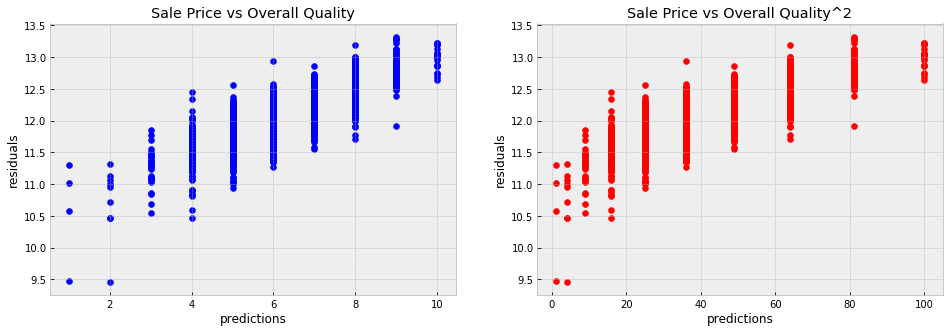

In [88]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax[0].scatter(X_sp_poly['overall_qual'], X_sp_poly['saleprice'], color='b')
ax[0].set_xlabel('predictions')
ax[0].set_ylabel('residuals');
ax[0].set_title('Sale Price vs Overall Quality')

ax[1].scatter(X_sp_poly['overall_qual^2'], X_sp_poly['saleprice'], color='r');
ax[1].set_xlabel('predictions')
ax[1].set_ylabel('residuals');
ax[1].set_title('Sale Price vs Overall Quality^2');

## Feature Engineering and Selection

### 1. Features with most correlation with Sale Price

In [19]:
features_basic = X_sp.corr()['saleprice'][X_sp.corr()['saleprice'].abs() > 0.5].sort_values(ascending=False)

features_basic.drop(labels='saleprice', inplace=True)

X[features_basic.index].to_csv('./datasets/X_corr.csv', index=False)
kaggle[features_basic.index].to_csv('./datasets/kaggle_corr.csv', index=False)

#### ** FEATURES **

In [20]:
features_basic

overall_qual        0.803336
gr_liv_area         0.719598
exter_qual          0.714895
kitchen_qual        0.694159
total_bsmt_sf       0.664912
garage_area         0.655571
garage_cars         0.648619
1st_flr_sf          0.648054
bsmt_qual           0.613160
year_built          0.572148
garage_finish       0.558576
garage_yr_blt       0.556405
year_remod/add      0.550614
fireplace_qu        0.539185
full_bath           0.538050
foundation_PConc    0.529226
mas_vnr_area        0.511760
totrms_abvgrd       0.510078
Name: saleprice, dtype: float64

### 2. Polynomial Features

Remove columns from X which are not present in Kaggle

In [21]:
X_sp.drop(columns=col_no_kag, axis=1, inplace=True)

Take the top most correlated variables to obtain polynomial features

In [22]:
poly_cols = X_sp.corr()['saleprice'][X_sp.corr()['saleprice'].abs() > 0.3].sort_values(ascending=False).index
poly_cols = poly_cols.drop('saleprice')

In [23]:
X_sp_corr = X_sp[poly_cols]
X_corr = X[poly_cols]
kaggle_corr = kaggle[poly_cols]

In [24]:
poly = PolynomialFeatures(include_bias=False)

In [25]:
X_sp_poly_values = poly.fit_transform(X_sp_corr)
X_sp_poly = pd.DataFrame(X_sp_poly_values, columns=poly.get_feature_names(poly_cols))

In [26]:
X_sp_poly['saleprice'] = y.values

In [27]:
X_poly_values = poly.fit_transform(X_corr)
X_poly = pd.DataFrame(X_poly_values, columns=poly.get_feature_names(poly_cols))

In [28]:
kaggle_poly_values = poly.fit_transform(kaggle_corr)
kaggle_poly = pd.DataFrame(kaggle_poly_values, columns=poly.get_feature_names(poly_cols))

In [29]:
X_poly.to_csv('./datasets/X_poly.csv', index=False)
kaggle_poly.to_csv('./datasets/kaggle_poly.csv', index=False)

Choosing the polynomial features with the best correlation

In [30]:
features_corr = X_sp_poly.corr()['saleprice'][X_sp_poly.corr()['saleprice'].abs() > 0.75].sort_values(ascending=False)

#### ** FEATURES **

In [31]:
features_corr.drop(labels='saleprice', inplace=True)

In [32]:
features_corr

overall_qual gr_liv_area       0.838521
overall_qual year_built        0.832268
overall_qual garage_yr_blt     0.831250
overall_qual year_remod/add    0.829949
overall_qual                   0.825484
overall_qual kitchen_qual      0.820868
gr_liv_area bsmt_qual          0.818469
overall_qual^2                 0.816254
overall_qual exter_qual        0.813825
gr_liv_area exter_qual         0.813012
overall_qual bsmt_qual         0.811650
overall_qual garage_cars       0.810973
gr_liv_area kitchen_qual       0.803923
overall_qual 1st_flr_sf        0.800597
overall_qual garage_area       0.798004
overall_qual total_bsmt_sf     0.787692
overall_qual totrms_abvgrd     0.787630
overall_qual heating_qc        0.777766
gr_liv_area garage_cars        0.777144
kitchen_qual garage_cars       0.773201
gr_liv_area heating_qc         0.772868
garage_cars bsmt_qual          0.771254
1st_flr_sf bsmt_qual           0.768240
garage_area bsmt_qual          0.766775
exter_qual garage_cars         0.766545


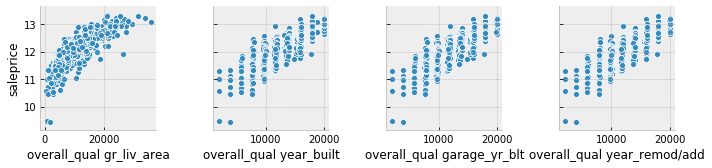

In [33]:
sns.pairplot(X_sp_poly, x_vars=['overall_qual gr_liv_area','overall_qual year_built','overall_qual garage_yr_blt',
                                'overall_qual year_remod/add'], y_vars=['saleprice']);

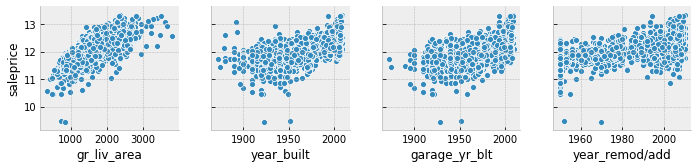

In [34]:
sns.pairplot(X_sp_poly, x_vars=['gr_liv_area','year_built','garage_yr_blt',
                                'year_remod/add'], y_vars=['saleprice']);

In [35]:
X_poly[features_corr.index].to_csv('./datasets/X_poly_corr.csv', index=False)
kaggle_poly[features_corr.index].to_csv('./datasets/kaggle_poly_corr.csv', index=False)

### 3. Hypothesis Testing of Polynomial Coefficients using OLS

In [36]:
X_poly = sm.add_constant(X_poly)

/Users/Sruthi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [37]:
ols = sm.OLS(y.values, X_poly).fit()

In [38]:
#ols.summary()

In [39]:
features_ols = []
for var in ols.pvalues.index:
    if ols.pvalues[var] < 0.04:
        features_ols.append(var)

for i in range(3):
    features_ols_loop = []
    for f in sm.OLS(y.values, X_poly[features_ols]).fit().pvalues.index:
        if sm.OLS(y.values, X_poly[features_ols]).fit().pvalues[f] < 0.04:
            features_ols_loop.append(f)
    features_ols = features_ols_loop

/Users/Sruthi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/Sruthi/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/Sruthi/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/Sruthi/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


#### ** FEATURES **

In [40]:
ols.pvalues[features_ols].sort_values()

overall_qual garage_area            0.000002
overall_qual garage_cars            0.000833
overall_qual garage_yr_blt          0.000909
1st_flr_sf garage_type_Detchd       0.003008
garage_area garage_yr_blt           0.003807
overall_qual^2                      0.003889
total_bsmt_sf garage_type_Detchd    0.004410
garage_cars garage_yr_blt           0.004535
garage_area open_porch_sf           0.005437
year_remod/add^2                    0.005547
overall_qual exter_qual             0.005593
lot_area^2                          0.012144
exter_qual garage_type_Detchd       0.016500
overall_qual heating_qc             0.016742
garage_finish foundation_CBlock     0.017234
lot_area garage_type_Detchd         0.018619
garage_finish foundation_PConc      0.018887
year_remod/add                      0.018918
total_bsmt_sf year_remod/add        0.023452
gr_liv_area totrms_abvgrd           0.024248
garage_type_Attchd lot_area         0.026202
sale_type_New                       0.026952
sale_type_

In [41]:
X_poly[features_ols].to_csv('./datasets/X_poly_ols.csv', index=False)
kaggle_poly[features_ols].to_csv('./datasets/kaggle_poly_ols.csv', index=False)

In [42]:
y.to_csv('./datasets/y.csv', header='saleprice',index=False)

#### ** Most Important Features for Prediction **

In [43]:
for f in features_ols:
    if f in features_corr.index:
        print(f)

overall_qual^2
overall_qual exter_qual
overall_qual garage_area
overall_qual garage_cars
overall_qual garage_yr_blt
overall_qual heating_qc


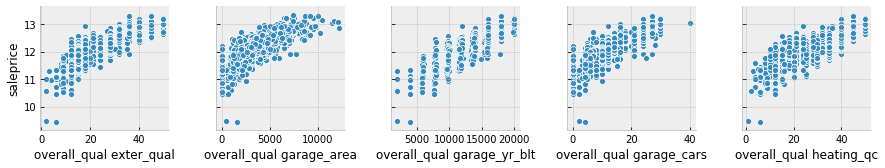

In [44]:
sns.pairplot(X_sp_poly, x_vars=['overall_qual exter_qual','overall_qual garage_area','overall_qual garage_yr_blt',
                                'overall_qual garage_cars','overall_qual heating_qc'], y_vars=['saleprice']);

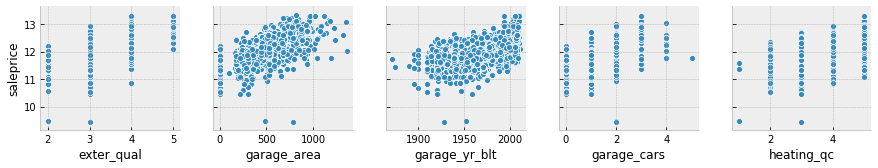

In [45]:
sns.pairplot(X_sp_poly, x_vars=['exter_qual','garage_area','garage_yr_blt',
                                'garage_cars','heating_qc'], y_vars=['saleprice']);